# Analysis of the iJO1366 metabolic ecoli network

In this analysis we explore the metabolism of E. coli more thoroughly and study the effects of employing different metabolites as carbon sources.

## Contents
* comparing minimal glucose and acetate environments
* identify subsystems of essential reactions
* rich environments
* carbon sources

## Load Libraries and the Model

In [1]:
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model
model = cobra.io.read_sbml_model("data/iJO1366.xml")

## Explore the Networks reactions, genes and metabolites

First we look at how many genes. reactions and genes the model contains, as well as set biomass as objective.

In [2]:

print("Number of reactions:", len(model.reactions))
print("Number of genes:", len(model.genes))
print("Number of metabolites:", len(model.metabolites))
print("Flux of optimal biomass production: ", model.optimize().objective_value)

Number of reactions: 2583
Number of genes: 1367
Number of metabolites: 1805
Flux of optimal biomass production:  0.9823718127269633


Now, we want to find external reactions that are currently active

In [11]:
fluxes = model.optimize().fluxes
active_react = list(fluxes[fluxes.round(3) > 0].index)

# print("Metabolites involved in external reactions: \n")
for react in model.reactions:
    # check whether active reaction
    if react.id in active_react:
        if "e" in react.get_compartments():
            print(", ".join([met.name for met in model.reactions.get_by_id(react.id).metabolites]))

10-Formyltetrahydrofolate, [2Fe-2S] iron-sulfur cluster, 2-Octaprenyl-6-hydroxyphenol, [4Fe-4S] iron-sulfur cluster, L-Alanine, S-Adenosyl-L-methionine, L-Arginine, L-Asparagine, L-Aspartate, ATP, Bis-molybdopterin guanine dinucleotide, Biotin, Calcium, Chloride, Coenzyme A, Co2+, CTP, Cu2+, L-Cysteine, DATP, DCTP, DGTP, DTTP, Flavin adenine dinucleotide oxidized, Fe2+, Fe3+, L-Glutamine, L-Glutamate, Glycine, GTP, H2O, L-Histidine, L-Isoleucine, Potassium, KDO(2)-lipid IV(A), L-Leucine, L-Lysine, L-Methionine, Magnesium, 5,10-Methylenetetrahydrofolate, Mn2+, Molybdate, Two disacharide linked murein units, pentapeptide crosslinked tetrapeptide (A2pm->D-ala) (middle of chain), Nicotinamide adenine dinucleotide, Nicotinamide adenine dinucleotide phosphate, Ammonium, Nickel, Phosphatidylethanolamine (dihexadecanoyl, n-C16:0), Phosphatidylethanolamine (dihexadecanoyl, n-C16:0), Phosphatidylethanolamine (dihexadec-9enoyl, n-C16:1), Phosphatidylethanolamine (dihexadec-9enoyl, n-C16:1), L-Phe

## Essential reactions in minimal glucose environment vs. minimal acetate environemt

Let's Find all essential reactions in the E. coli metabolic network for growth in a minimal glucose-containing environment. What fractions of the total reactions are essential?

In [4]:
if __name__ == "__main__":
    from cobra.flux_analysis import single_reaction_deletion

    # set all to zero except Glucoset to obtain minimal glucose env
    for react in model.exchanges:
        if react.id != "EX_glc__D_e": # it not glucose
            for met in react.metabolites:
                if "C" in met.elements.keys():
                    react.lower_bound = 0 # set production to zero to get minimal glucose system

    deletion_results = single_reaction_deletion(model)
    # we also include the infeasible case, to find deletions where no reaction could be found
    mask = np.logical_or(deletion_results["status"] == "infeasible", deletion_results["growth"].round(3) == 0)
    essential_ids = deletion_results[mask]["ids"]
    print("Fraction of TOTAL versus ESSENTIAL reactions:", len(essential_ids) / len(model.reactions))

Fraction of total versus essential reactions: 0.1118854045683314


Now, we compare this result with the fraction of essential reactions in an minimal acetate environment. We see that the fraction is higher for growth in a minimal acetate environment, which means that growth on only acetate requires more different reactions than on glucose.

In [5]:
if __name__ == "__main__":
    from cobra.flux_analysis import single_reaction_deletion

    # reload
    model = cobra.io.read_sbml_model("data/iJO1366.xml")

    # set all to zero except Acetate to obtain minimal acetate env
    for react in model.exchanges:
        # print(react.id, react.name) to find the id of the acetate reaction
        if react.id != "EX_ac_e": # it not acetate
            for met in react.metabolites:
                if "C" in met.elements.keys():
                    react.lower_bound = 0 # set production to zero to get minimal acetate system
    model.exchanges.get_by_id("EX_ac_e").lower_bound = -10. # as in glucose

    deletion_results = single_reaction_deletion(model)
    mask = np.logical_or(deletion_results["status"] == "infeasible", deletion_results["growth"].round(4) == 0)
    essential_ids = deletion_results[mask]["ids"]
    print("Fraction of TOTAL versus ESSENTIAL reactions:", len(essential_ids) / len(model.reactions))

Fraction of total versus essential reactions: 0.11498257839721254
The fraction is higher for growth on acetate!


Now we analyse how these essential reactions differ and which ones they are:

In [7]:
if __name__ == "__main__":
    from cobra.flux_analysis import single_reaction_deletion

    # reload
    model = cobra.io.read_sbml_model("data/iJO1366.xml")

    #set all to zero except Glucoset to obtain minimal glucose env
    for react in model.exchanges:
        if react.id != "EX_glc__D_e": #if not glucose
            for met in react.metabolites:
                if "C" in met.elements.keys():
                    react.lower_bound = 0 #set production to zero to get minimal glucose system

    deletion_results = single_reaction_deletion(model)
    mask = np.logical_or(deletion_results["status"] == "infeasible", deletion_results["growth"].round(5) == 0)
    essential_ids_glucose = [list(i)[0] for i in deletion_results[mask]["ids"]]
    # print("Fraction of total versus essential reactions in glucose:", len(essential_ids_glucose) / len(model.reactions))

    model = cobra.io.read_sbml_model("data/iJO1366.xml")
    #set all to zero except Acetate to obtain minimal acetate env
    for react in model.exchanges:
        # print(react.id, react.name) to find the id of the acetate reaction
        if react.id != "EX_ac_e": # if not acetate
            for met in react.metabolites:
                if "C" in met.elements.keys():
                    react.lower_bound = 0 # set production to zero to get minimal acetate system
    model.exchanges.get_by_id("EX_ac_e").lower_bound = -10. # as in glucose

    deletion_results = single_reaction_deletion(model)
    mask = np.logical_or(deletion_results["status"] == "infeasible", deletion_results["growth"].round(5) == 0)
    essential_ids_acetate = [list(i)[0] for i in deletion_results[mask]["ids"]]
    #  print("Fraction of total versus essential reactions for acetate:", len(essential_ids_acetate) / len(model.reactions))

    common_essentials = []
    diff_essentials = []
    for id in essential_ids_acetate:
        if id in essential_ids_glucose:
            common_essentials.append(id)
        else:
            diff_essentials.append(id)

    print(f"Number of common reactions is {len(common_essentials)} and number of different reactions is {len(diff_essentials)}")

Fraction of total versus essential reactions in glucose: 0.1118854045683314
Fraction of total versus essential reactions for acetate: 0.11498257839721254
Number of common reactions is 288 and number of different reactions is 9


## Essential subsystems

Next, we use the file *iJO1366_reactionInfo.csv* to find out how many essential reactions on glucose occur in each metabolic pathway (or subsystem). Which pathway is the one with the most essential reactions?
Understanding the metabolic pathway in which essential reactions occur can provide useful biological information, because pathways with many essential reactions are arguably more important for survival in a specific chemical environment.

In [23]:
if __name__ == "__main__":

    model = cobra.io.read_sbml_model("data/iJO1366.xml")
    info = pd.read_csv("../iJO1366_reactionInfo.csv", sep = ",")

    # set all to zero except Glucoset to obtain minimal glucose env
    for react in model.exchanges:
        if react.id != "EX_glc__D_e": # it not glucose
            for met in react.metabolites:
                if "C" in met.elements.keys():
                    react.lower_bound = 0 # set production to zero to get minimal glucose system

    deletion_results = single_reaction_deletion(model)
    mask = np.logical_or(deletion_results["status"] == "infeasible", deletion_results["growth"].round(5) == 0)
    essential_ids_glucose = [list(i)[0] for i in deletion_results[mask]["ids"]]
    mask = info["Reaction Abbreviation"].isin(essential_ids_glucose)
    # print("Subsystem and its importance:")
    # print(info[mask].groupby("Subsystem")["Reaction Abbreviation"].count().sort_values(ascending = False))
    subsys = info[mask].groupby("Subsystem")["Reaction Abbreviation"].count().sort_values(ascending = True)

Text(0.5, 0, 'counts')

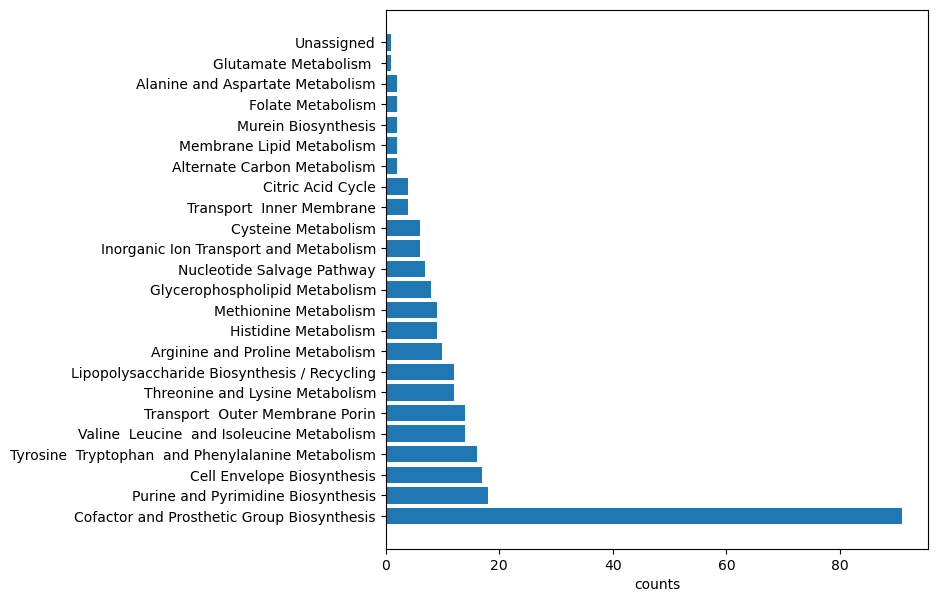

In [21]:
plt.figure(figsize = (7, 7))
plt.barh(y = subsys.index, width = subsys.values)
plt.xlabel("counts")

## Rich environemts

Before we identified essential reactions for growth in a glucose minimal environment. Now we compute these reactions for the rich environment specified by the file *rich_environment.txt*. For a gut bacterium such as E. coli, which of these environments may be more realistic? Is the number of essential reactions for growth in these environments different?

In [26]:
if __name__ == "__main__":


    model = cobra.io.read_sbml_model("data/iJO1366.xml")
    # reading in as csv is to problematic,, solve here
    # rich = pd.read_csv("rich_environment.txt", sep = " = ", names = ["metabolites", "bound"], engine = "python")
    f = open("../rich_environment.txt")
    rich = {}
    for line in f:
        key = "EX_" + line.split()[0]
        value = line.split()[-1]
        rich[key] = int(value)
    # print(rich)

    # apply the rich rich_environment
    for key in rich.keys():
        model.exchanges.get_by_id(key).lower_bound = rich[key]

    # optimize the model
    deletion_results = single_reaction_deletion(model)
    mask = np.logical_or(deletion_results["status"] == "infeasible", deletion_results["growth"].round(5) == 0)
    essential_ids = [list(i)[0] for i in deletion_results[mask]["ids"]]

    print("Number of essential reactions in rich environment:", len(essential_ids))


Number of essential reactions in rich environment: 205


We find that there are less essential reactions in the rich environment than in both environments, which makes sense due to the broader availabilty of resources. It is more likely for a gut bacterium to live in a rich environment as the gut hold various resources and is a changing environment.

## Carbon sources in aerobic and anaerobic environment

Next, we search for the metabolites that have the potential to be carbon sources and calculate the maximum growth achievable on each. We compare the carbon source in an aerobic an anaerobic environment.

In [35]:
if __name__ == "__main__":
    import warnings
    warnings.filterwarnings("ignore")

    model = cobra.io.read_sbml_model("data/iJO1366.xml")
    # search for metabolites with potenital of being a carbon source
    Csources = []
    for react in model.exchanges:
        for met in react.metabolites:
            if "C" in met.elements.keys():
                Csources.append(react.id)

    print("Total number of possible carbon sources:", len(Csources))
    # find the oxic reaction
    for react in model.exchanges:
        for met in react.metabolites:
            if "O" in met.elements.keys():
                if met.formula == "O2":
                    if not "s" in list(react.id):
                        OX_id = react.id


    mini_Csource = pd.DataFrame(data = {n:np.nan for n in ["aerobic", "anaerobic"]}, index = Csources)
    # optimze for all single carbon sources and append to dict
    for mini_id in Csources:
        model_ = model.copy()
        for react in model_.exchanges:
            if react.id != mini_id:
                react.lower_bound = 0.
            else:
                react.lower_bound = -1000.
        # aerobic conditions
        model_.exchanges.get_by_id(OX_id).lower_bound = -1000.
        sol = model_.optimize()
        mini_Csource.loc[mini_id, "aerobic"] = sol.objective_value
        # anaerobic conditions
        model_.exchanges.get_by_id(OX_id).lower_bound = 0.
        sol = model_.optimize()
        mini_Csource.loc[mini_id, "anaerobic"] = sol.objective_value

    # print(mini_Csource)

Total number of possible carbon sources: 285


In [65]:
# wrangle dataframe to plot

# drop only 0 rows
source_df = mini_Csource[(mini_Csource != 0).any(axis = 1)]
aerobic = source_df["aerobic"][source_df["aerobic"] != 0]
anaerobic = source_df["anaerobic"][source_df["anaerobic"] != 0]
source_only = source_df[(source_df != 0).all(axis = 1)]

print(f"There are only {len(source_only)} carbon sources that can be used in aerobic and anaerobic environments. The sources are the following:")
print(", ".join([j.name for i in source_only.index for j in model.reactions.get_by_id(i).metabolites]))

There are only 14 carbon sources that can be used in aerobic and anaerobic environments. The sources are the following:
3'-AMP, Acetaldehyde, Deoxyadenosine, Dihydroxyacetone, D-Fructuronate, Beta D-Galactose, D-Glucosamine, D-Glucuronate, (R)-Glycerate, GMP, L-Malate, 2(alpha-D-Mannosyl)-D-glycerate, D-tartrate, Trehalose


I hope you enjoyed this analysis of the ecoli core network!